In [23]:
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pickle
import xarray as xr
import torch
import torch.nn as nn
from scipy import interpolate
from geopack import geopack
import datetime

In [24]:
def open_reppu(hemi, feature):

    ds = xr.open_dataset(f'/run/media/sachin/0fa21ddb-f70c-4238-9cf4-705e0360f1c1/NIPR/data/REPPU/smrai3/NICT_Data/{hemi}/multi/{hemi}_2020-2024_{feature}_feats_140_40_2min_rtsw.nc')
    #ds = ds.sel(dt=slice('2021-12-16 00:00:00',' 2021-12-16 12:00:00'))
    #ds = ds.sel(dt=slice('2022-09-17 15:00:00','2022-09-17 23:00:00'))
    #ds = ds.sel(dt=slice('2023-03-17 15:00:00','2023-03-17 21:00:00'))

    ds = ds.sel(dt=slice('2023-03-23 15:00:00','2023-03-24 23:59:00')) #kp7

   
    df = ds.to_dataframe().reset_index()
    df = df.drop_duplicates(subset=['dt'])
    df = df.drop(columns=['lat', 'lon'])
    var = df.pop(feature)
    df = df[['dt','By', 'Bz', 'vsw', 'np', 'tilt_angle']]

    vals = ds[feature][:-30,:,:].values

    return df,  vals

pot_df, pot_vals = open_reppu('NH', 'pot')
fac_df, fac_vals = open_reppu('NH', 'fac')
sxx_df, sxx_vals = open_reppu('NH', 'sxx')
syy_df, syy_vals = open_reppu('NH', 'syy')
sxy_df, sxy_vals = open_reppu('NH', 'sxy')

In [25]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 40 * 140)

    def forward(self, x):
        batch_size = x.size(0)
        # Use the same device as the model for hidden states
        device = next(self.parameters()).device  # Ensure hidden states are on the same device as the model
        
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size, device=device)  # Initial hidden state
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size, device=device)  # Initial cell state
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        out = out.view(-1, 40, 140)
        return out

    def reset_states(self):
        # Reset the internal states of the LSTM layer
        self.lstm.reset_parameters()

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
lookback = 30
def load_model(model_path,lookback=30):


    model = LSTM(lookback, 128, 2)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    model.to(device)

    return model

#NH
NH_pot_model = load_model("/home/sachin/Documents/NIPR/Research/Data/ML/SMRAI3/smrai3_model_pot_NH_id4.pt")
NH_fac_model = load_model("/home/sachin/Documents/NIPR/Research/Data/ML/SMRAI3/smrai3_model_fac_NH_id4.pt")
NH_sxx_model = load_model("/home/sachin/Documents/NIPR/Research/Data/ML/SMRAI3/smrai3_model_sxx_NH_id3.pt") 
NH_syy_model = load_model("/home/sachin/Documents/NIPR/Research/Data/ML/SMRAI3/smrai3_model_syy_NH_id3.pt")
NH_sxy_model = load_model("/home/sachin/Documents/NIPR/Research/Data/ML/SMRAI3/smrai3_model_sxy_NH_id3.pt")


In [26]:
'''path = '/home/sachin/Documents/NIPR/Research/Data/OMNI/omni_hro_1min_2013-05.csv'
df = pd.read_csv(path)
df['dt'] = pd.to_datetime(df['dt'])
df = df[df['dt'].between('2013-05-14 04:00:00','2013-05-14 08:30:00')]
#resample to two minutes
df=df.set_index('dt').resample('2min').mean().dropna().reset_index()
df'''

"path = '/home/sachin/Documents/NIPR/Research/Data/OMNI/omni_hro_1min_2013-05.csv'\ndf = pd.read_csv(path)\ndf['dt'] = pd.to_datetime(df['dt'])\ndf = df[df['dt'].between('2013-05-14 04:00:00','2013-05-14 08:30:00')]\n#resample to two minutes\ndf=df.set_index('dt').resample('2min').mean().dropna().reset_index()\ndf"

In [27]:
lookback = 30

def make_predictions(model, df, hemi, feat, id):

    def split_to_df(df):
        df_2 = df.copy()
        df_2 = df_2.drop(columns=['dt'])

        return df, df_2

    with open(f'/home/sachin/Documents/NIPR/Research/Data/ML/SMRAI3/smrai3_scaler_{feat}_{hemi}_id{id}.pkl', 'rb') as f:
        scaler = pickle.load(f)

    df_raw, df_proc= split_to_df(df)
    col_names = df_proc.columns

    norm_arr = scaler.transform(df_proc)
    df_proc = pd.DataFrame(norm_arr, columns=col_names)
    df_proc = df_proc.to_numpy()

    def create_sequences(arr, lookback=lookback):
        X = []
        for i in range(len(arr) - lookback):
            X.append(arr[i:i+lookback].T)

        X = np.array(X)

        return X

    proc_seq = create_sequences(df_proc)
    proc_seq = torch.tensor(proc_seq, dtype=torch.float32).to(device)


    predictions = []
    with torch.no_grad():
        for i in range(len(proc_seq)):
            pred = model(proc_seq[i].unsqueeze(0))
            predictions.append(pred)

    predictions = torch.cat(predictions)
    predictions = predictions.to('cpu').numpy()

    return predictions, df_raw

pot_predictions, NH_pot_raw = make_predictions(NH_pot_model, pot_df, 'NH', 'pot', 3)
fac_predictions, NH_fac_raw = make_predictions(NH_fac_model, fac_df, 'NH', 'fac', 3)
sxx_predictions, NH_raw = make_predictions(NH_sxx_model, sxx_df, 'NH', 'sxx', 1)
syy_predictions, NH_raw = make_predictions(NH_syy_model, syy_df, 'NH', 'syy', 1)
sxy_predictions, NH_raw = make_predictions(NH_sxy_model, sxy_df, 'NH', 'sxy', 1)


/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [28]:
#real_pot = pot_vals - lookback

lstm_ds = xr.Dataset({'pot': (['dt', 'mlat', 'mlt'], pot_predictions),
                      'pot_ground': (['dt', 'mlat', 'mlt'], pot_vals),
                      'fac': (['dt', 'mlat', 'mlt'], -fac_predictions),
                      'fac_ground': (['dt', 'mlat', 'mlt'], -fac_vals),
                         'sxx': (['dt', 'mlat', 'mlt'], sxx_predictions),
                         'sxx_ground': (['dt', 'mlat', 'mlt'], sxx_vals),
                         'syy': (['dt', 'mlat', 'mlt'], syy_predictions),
                         'syy_ground': (['dt', 'mlat', 'mlt'], syy_vals),
                         'sxy': (['dt', 'mlat', 'mlt'], sxy_predictions),
                         'sxy_ground': (['dt', 'mlat', 'mlt'], sxy_vals),
                      'BY_GSE': (['dt'], NH_pot_raw['By'].values[lookback:]),
                      'BZ_GSE': (['dt'], NH_pot_raw['Bz'].values[lookback:]),
                      'flow_speed': (['dt'], NH_pot_raw['vsw'].values[lookback:]),
                      'proton_density': (['dt'], NH_pot_raw['np'].values[lookback:]),
                      'tilt_angle': (['dt'], NH_pot_raw['tilt_angle'].values[lookback:]),
                 },
                coords = {'dt': NH_pot_raw['dt'].values[lookback:], 'mlat': np.linspace(50, 90, 40), 'mlt': np.linspace(0, 360, 140)})

lstm_ds

<xarray.Dataset> Size: 215MB
Dimensions:         (dt: 960, mlat: 40, mlt: 140)
Coordinates:
  * dt              (dt) datetime64[ns] 8kB 2023-03-23T16:00:00 ... 2023-03-2...
  * mlat            (mlat) float64 320B 50.0 51.03 52.05 ... 87.95 88.97 90.0
  * mlt             (mlt) float64 1kB 0.0 2.59 5.18 7.77 ... 354.8 357.4 360.0
Data variables: (12/15)
    pot             (dt, mlat, mlt) float32 22MB 1.553 1.495 ... -26.65 -26.58
    pot_ground      (dt, mlat, mlt) float32 22MB 9.127 8.89 ... -23.38 -23.45
    fac             (dt, mlat, mlt) float32 22MB 3.908e-05 ... -0.09751
    fac_ground      (dt, mlat, mlt) float32 22MB -0.0 -0.0 ... -0.1253 -0.1224
    sxx             (dt, mlat, mlt) float32 22MB 1.958 1.955 ... 2.145 2.138
    sxx_ground      (dt, mlat, mlt) float32 22MB 1.956 1.956 ... 2.605 2.604
    ...              ...
    sxy_ground      (dt, mlat, mlt) float32 22MB 1.625 1.625 ... 2.609 2.607
    BY_GSE          (dt) float64 8kB 18.0 18.8 18.85 19.25 ... -6.65 -6.55 -6.45
    BZ_GSE          (dt) float64 8kB -6.475 -3.145 -2.63 0.55 ... 2.08 1.76 1.44
    flow_speed      (dt) float64 8kB 478.3 480.5 479.9 ... 456.7 457.3 458.0
    proton_density  (dt) float64 8kB 8.84 8.66 8.62 8.39 ... 6.85 6.6 6.66 6.72
    tilt_angle      (dt) float64 8kB 0.1757 0.176 0.1764 ... -0.01343 -0.01477

<xarray.Dataset> Size: 44MB
Dimensions:         (dt: 960, mlat: 25, mlt: 46)
Coordinates:
  * dt              (dt) datetime64[ns] 8kB 2023-03-23T16:00:00 ... 2023-03-2...
  * mlat            (mlat) float64 200B 60.26 61.28 62.31 ... 82.82 83.85 84.87
  * mlt             (mlt) float64 368B 14.16 14.33 14.5 ... 21.58 21.76 21.93
Data variables: (12/15)
    pot             (dt, mlat, mlt) float32 4MB 0.5573 0.6532 ... -18.23 -18.52
    pot_ground      (dt, mlat, mlt) float32 4MB 3.959 4.759 ... -13.08 -13.55
    fac             (dt, mlat, mlt) float32 4MB nan nan nan nan ... nan nan nan
    fac_ground      (dt, mlat, mlt) float32 4MB nan nan nan nan ... nan nan nan
    sxx             (dt, mlat, mlt) float32 4MB 6.713 6.689 6.66 ... 1.731 1.723
    sxx_ground      (dt, mlat, mlt) float32 4MB 6.905 6.911 ... 2.036 1.995
    ...              ...
    sxy_ground      (dt, mlat, mlt) float32 4MB 6.587 6.588 ... 2.104 2.063
    BY_GSE          (dt) float64 8kB 18.0 18.8 18.85 19.25 ... -6.65 -6.55 -6.45
    BZ_GSE          (dt) float64 8kB -6.475 -3.145 -2.63 0.55 ... 2.08 1.76 1.44
    flow_speed      (dt) float64 8kB 478.3 480.5 479.9 ... 456.7 457.3 458.0
    proton_density  (dt) float64 8kB 8.84 8.66 8.62 8.39 ... 6.85 6.6 6.66 6.72
    tilt_angle      (dt) float64 8kB 0.1757 0.176 0.1764 ... -0.01343 -0.01477

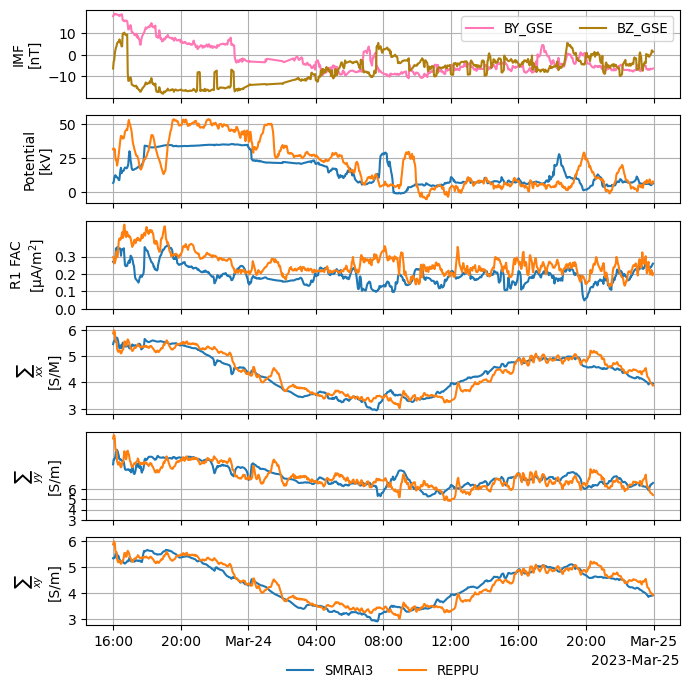

In [29]:
def plot_line(ds):
    ds = ds.copy()

    ds['mlt'] = ds['mlt'] /15
    #return ds

    ds = ds.sel(mlat=slice(60, 85), mlt=slice(14, 22))
    #keep data between 14 and 22 MLT and nan/mask the rest
    #ds = ds.where((ds['mlt'] >= 14) & (ds['mlt'] <= 23.9), np.nan)
    #ds['pot'] = ds['pot'].where(ds['pot'] > 1)
    #s['pot_ground'] = ds['pot_ground'].where(ds['pot_ground'] > 0)
    ds['fac'] = ds['fac'].where(ds['fac'] > 0)
    ds['fac_ground'] = ds['fac_ground'].where(ds['fac_ground'] > 0)

    #ds['fac'] = ds['fac'].where(ds['fac'] > 0)

    #slice between 14 and 16 mlt
    fig, ax = plt.subplots(6,1,figsize=(7, 7),sharex=True)

    ds['BY_GSE'].plot(ax=ax[0], label='BY_GSE', color = '#ff77b4')
    ds['BZ_GSE'].plot(ax=ax[0], label='BZ_GSE', color = '#af7f0e')
    ax[0].legend(loc='upper right',shadow=False, ncol=5, frameon=True, fontsize=9.5)
    ax[0].set_ylabel('IMF\n[nT]')
    ax[0].set_xlabel(' ')
    ax[0].set_yticks([-10, 0, 10])


    ds['pot'].mean(dim=['mlt','mlat']).plot(ax=ax[1], label='SMRAI3')
    ds['pot_ground'].mean(dim=['mlt','mlat']).plot(ax=ax[1], label='REPPU')
    ax[1].set_ylabel('Potential\n[kV]')
    ax[1].set_xlabel(' ')

    ds['fac'].mean(dim=['mlt','mlat']).plot(ax=ax[2], label='SMRAI3')
    ds['fac_ground'].mean(dim=['mlt','mlat']).plot(ax=ax[2], label='REPPU')
    fac_lab = r'$\mathregular{\mu A/m^2}$'
    ax[2].set_ylabel(f'R1 FAC\n[{fac_lab}]')
    ax[2].set_xlabel(' ')
    ax[2].set_yticks([0, 0.1, 0.2, 0.3])

    ds['sxx'].mean(dim=['mlt','mlat']).plot(ax=ax[3], label='SMRAI3')
    ds['sxx_ground'].mean(dim=['mlt','mlat']).plot(ax=ax[3], label='REPPU')
    sum_lab = r'$\sum_{xx}$'
    ax[3].set_ylabel(f'{sum_lab}\n[S/M]')
    ax[3].set_xlabel(' ')
    ax[3].set_yticks([3,4,5,6])


    sum_lab = r'$\sum_{yy}$'
    ds['syy'].mean(dim=['mlt','mlat']).plot(ax=ax[4], label='SMRAI3')
    ds['syy_ground'].mean(dim=['mlt','mlat']).plot(ax=ax[4], label='REPPU')
    ax[4].set_ylabel(f'{sum_lab}\n[S/m]')
    ax[4].set_xlabel(' ')
    ax[4].set_yticks([3,4,5,6])

    sum_lab = r'$\sum_{xy}$'
    ds['sxy'].mean(dim=['mlt','mlat']).plot(ax=ax[5], label='SMRAI3')
    ds['sxy_ground'].mean(dim=['mlt','mlat']).plot(ax=ax[5], label='REPPU')
    ax[5].set_ylabel(f'{sum_lab}\n[S/m]')
    ax[5].set_yticks([3,4,5,6])
    ax[5].set_xlabel(' ')
    ax[5].legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), shadow=False, ncol=5, frameon=False, fontsize=9.5)
    plt.tight_layout()

    for axs in ax:
        axs.grid(True)

    fig.subplots_adjust(hspace=0.2)
    #plt.savefig('smrai3_20220917_panel.png', dpi=400)
    
    return ds

plot_line(lstm_ds)

ValueError: cannot reshape array of size 0 into shape (40,140)

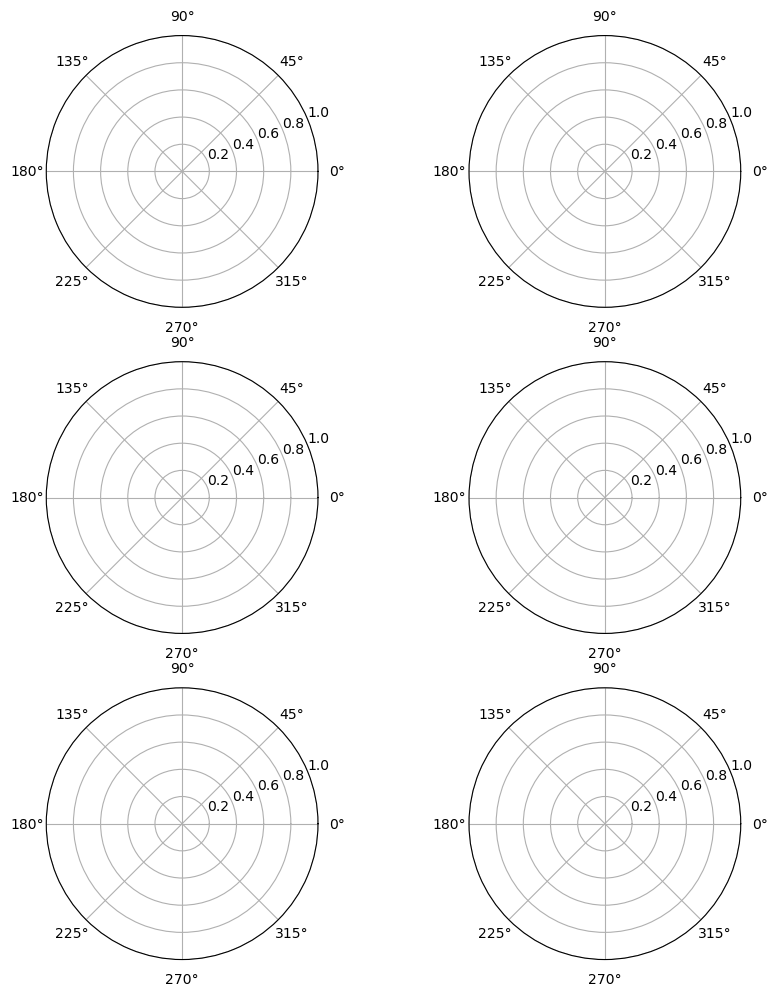

In [30]:
def plot_substorm(ds):
    fig, ax = plt.subplots(3, 2, figsize=(10, 12), sharex=True, sharey=False, subplot_kw={'projection': 'polar'})

    theta = np.linspace(0, 360, 140) - 90
    theta_rad = np.deg2rad(theta)
    r = 90 - np.linspace(50, 90, 40)

    dt_str = '2022-09-17T21:00:00'

    ds = ds.sel(dt=slice(dt_str, dt_str))

    pot_pred = ds['pot'].values.reshape(40, 140)
    pot_true = ds['pot_ground'].values.reshape(40, 140)

    fac_pred = ds['fac'].values.reshape(40, 140)
    fac_true = ds['fac_ground'].values.reshape(40, 140)

    sxy_pred = ds['sxy'].values.reshape(40, 140)
    sxy_true = ds['sxy_ground'].values.reshape(40, 140)

    # Plotting each subplot directly
    c1 = ax[0, 0].pcolormesh(theta_rad, r, pot_pred,cmap='PuOr', vmin=-30, vmax=30)
    c2 = ax[0, 1].pcolormesh(theta_rad, r, pot_true,cmap='PuOr', vmin=-30, vmax=30)

    plt.colorbar(c2, ax=ax[0, 1], orientation='vertical', extend='both', label='kV', shrink=0.6, pad = 0.15)

    c3 = ax[1, 0].pcolormesh(theta_rad, r, fac_pred, cmap='bwr', vmin=-1, vmax=1)
    c4 = ax[1, 1].pcolormesh(theta_rad, r, fac_true, cmap='bwr', vmin=-1, vmax=1)
    plt.colorbar(c4, ax=ax[1, 1], orientation='vertical', extend='both', label=r'$\mu A/m^2$', shrink=0.6, pad = 0.15)

    c5 = ax[2, 0].pcolormesh(theta_rad, r, sxy_pred, cmap='cividis', vmin=2, vmax=6)
    c6 = ax[2, 1].pcolormesh(theta_rad, r, sxy_true, cmap='cividis', vmin=2, vmax=6)
    plt.colorbar(c6, ax=ax[2, 1], orientation='vertical',extend='both',  label='S/m', shrink=0.6, pad = 0.15)

    for axs in ax.flatten():
        axs.set_ylim([0, 37])
        axs.set_yticks([0, 10, 20, 30])
        axs.set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
        axs.set_xlim([-np.pi, np.pi])
        axs.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
        axs.set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n  Dawn", "9", "12 MLT \nMidday", "15", "18 \nDusk"])
        axs.grid(True, linestyle='-', linewidth=0.5, zorder=6)


    plt.annotate('SMRAI3\n(Prediction)', xy=(0, 0), xytext=(-1.01, -0.28), textcoords='axes fraction', fontsize=12, ha='center', va='center', color='black')
    plt.annotate('REPPU\n(Ground)', xy=(0, 0), xytext=(0.52, -0.28), textcoords='axes fraction', fontsize=12, ha='center', va='center', color='black')

    #set supertitle
    fig.suptitle(dt_str[:-3], fontsize=12, y=1)


    plt.tight_layout()
    fig.subplots_adjust(hspace=0.4,wspace=-0.08)
    #plt.savefig('smrai3_20220917_2100.png', dpi=400)

# Call the function with your dataset
plot_substorm(lstm_ds)
